In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

In [3]:
#Reutrieve data
from StockMarket import retriving_data
data_source = 'alphavantage' # alphavantage or kaggle
df_data = retriving_data(data_source)

File already exists. Loading data from CSV


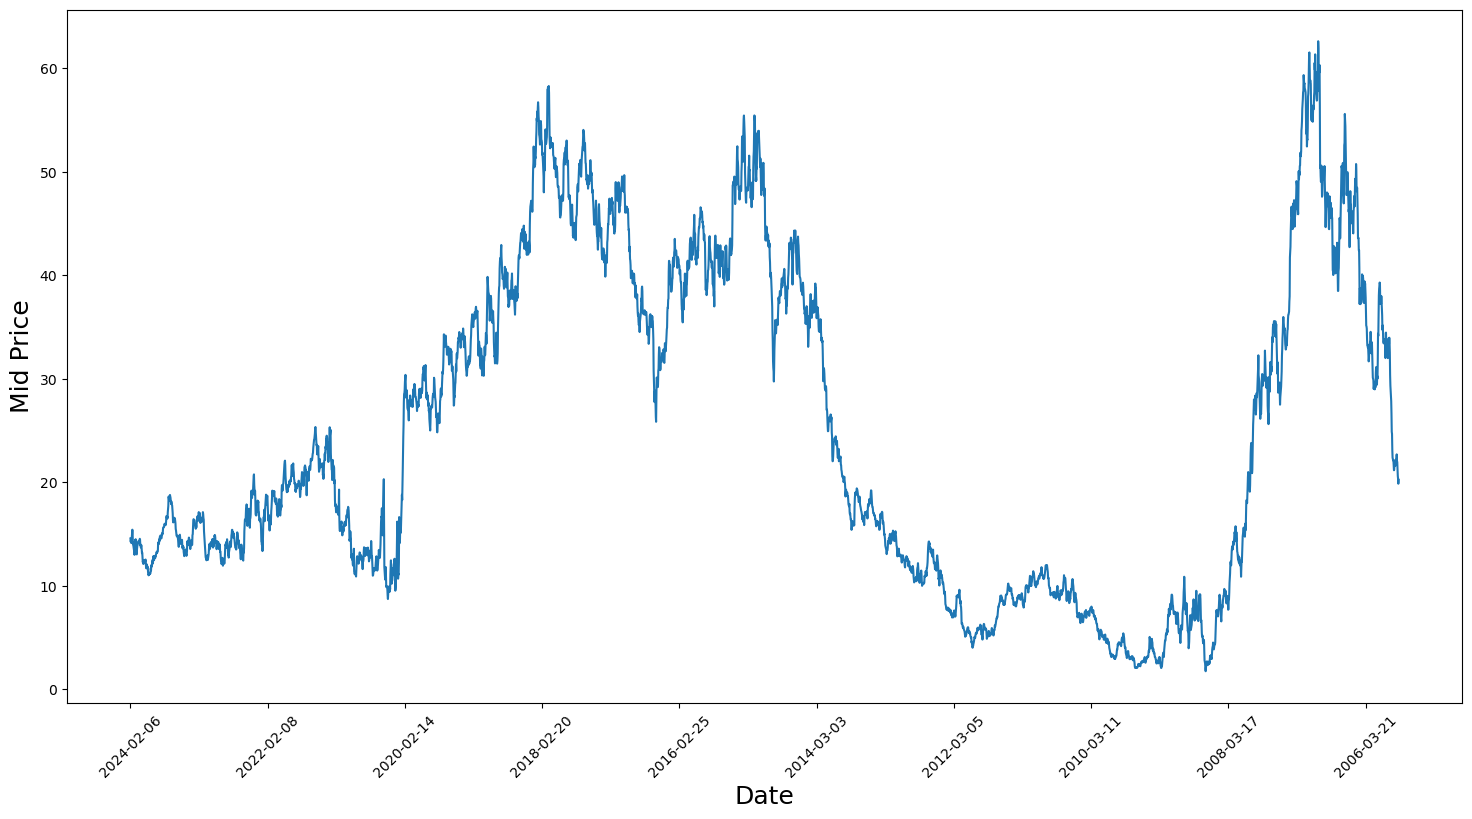

In [8]:
#Show data
from StockMarket import data_exploration, data_visualization
data_exploration(df_data)
data_visualization(df_data)
# df_data.head()

In [27]:
# Data preperation for averaging
from StockMarket import splitting_data, data_normalization1
train_data ,test_data = splitting_data(df_data)
train_data ,test_data, all_mid_data = data_normalization1(train_data ,test_data)


MSE error for standard averaging: 0.00272


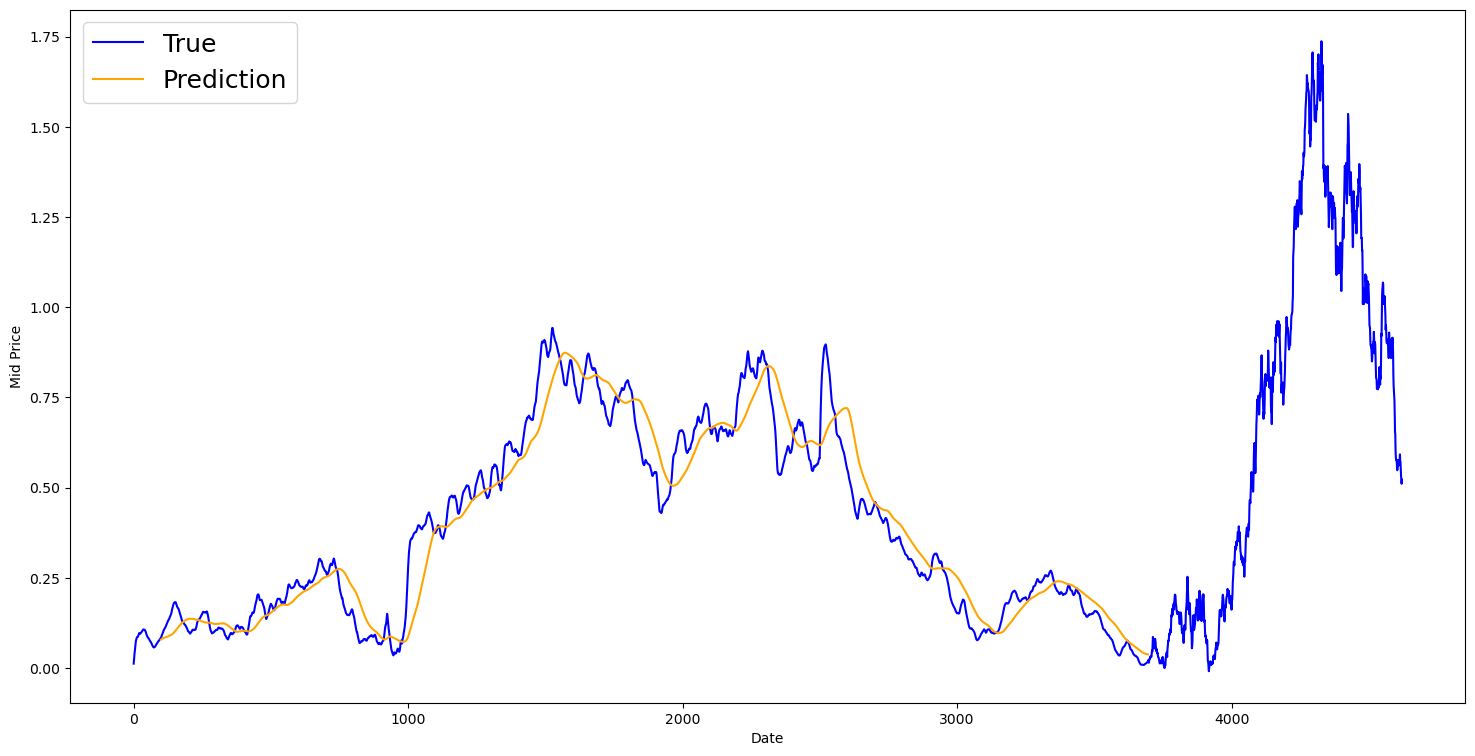

In [28]:
#Make prediction via averaging
from StockMarket import predict_via_avaraging
predict_via_avaraging(train_data ,test_data, all_mid_data, df_data)

MSE error for EMA averaging: 0.00002


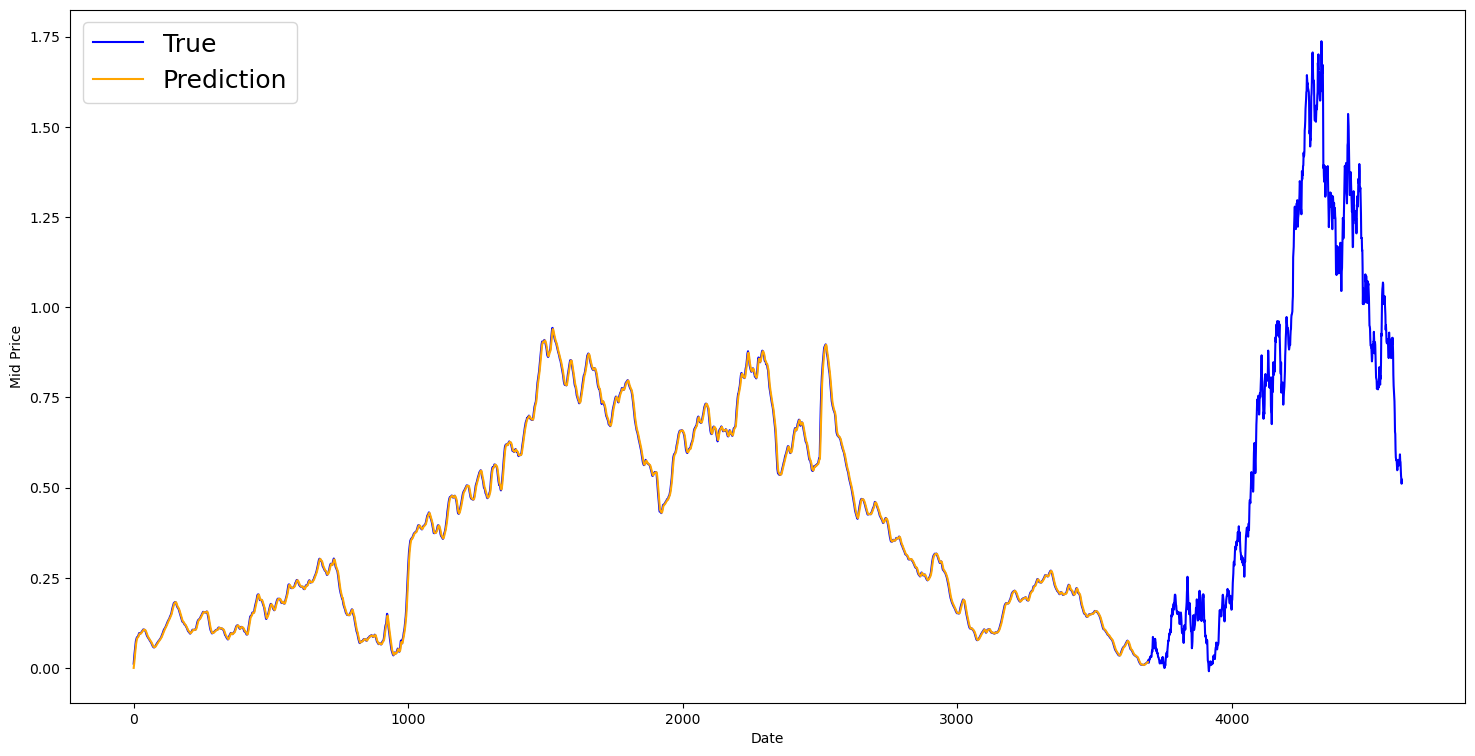

In [29]:
# Make prediction via moving avarage
from StockMarket import moving_avarage
preds = moving_avarage(train_data ,test_data, all_mid_data, df_data)

In [17]:
#Initialize variables
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 300
lr = 0.01
dropout = 0.2
LOOK_BACK = 30
look_ahead = 20


In [18]:
# Data preperation for LSTM
from StockMarket import split_train_test, data_normalization
norm_data, min_val, max_val = data_normalization(df_data)
x_train, y_train, x_val, y_val, x_test, y_test = split_train_test(
    norm_data, 0.8, LOOK_BACK, look_ahead)

In [ ]:
from StockMarket import split_train_test, data_normalization, create_dataset
X, y = create_dataset(df_data, LOOK_BACK, look_ahead)
split_data

In [19]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
y_val = y_val.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

seq_size = x_train.shape[0]

In [27]:
# Creating LSTM model
from StockMarket import LSTM
model = LSTM(input_dim=input_dim,
             hidden_dim=hidden_dim,
             num_layers=num_layers,
             output_dim=output_dim,
             seq_size=seq_size,
             dropout=dropout)
loss_function = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Train model
from StockMarket import train_model
train_model(model,
            optimiser,
            loss_function,
            x_train, y_train,
            x_val, y_val,
            num_epochs,
            look_ahead)

In [78]:
# Predicting
from StockMarket import re_scale_data
model.eval()

train_pred_scaled = model(x_train)
train_pred_scaled = train_pred_scaled.data.numpy()
train_pred = re_scale_data(train_pred_scaled, min_val, max_val)
y_train_orig = re_scale_data(y_train.data.numpy(), min_val, max_val)

pred_scaled = model(x_test)
pred_scaled = pred_scaled.data.numpy()

pred = re_scale_data(pred_scaled, min_val, max_val)
y_test_orig = re_scale_data(y_test.data.numpy(), min_val, max_val)

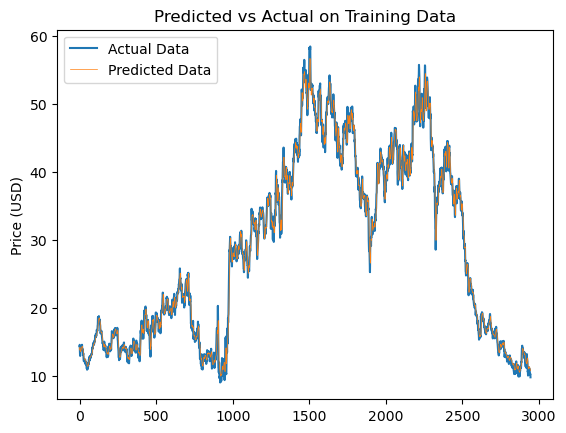

In [79]:
# Plotting Predicted vs Actual on Training Data
plt.figure()
plt.plot(y_train_orig, label='Actual Data')
plt.plot(train_pred, label='Predicted Data', linewidth=0.5)
plt.title("Predicted vs Actual on Training Data")
plt.ylabel("Price (USD)")
plt.legend()
plt.show() 

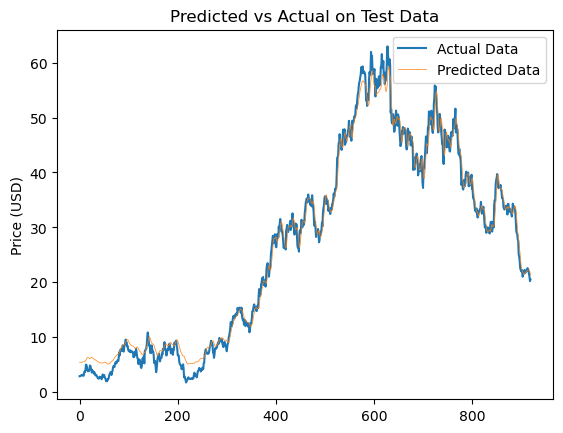

In [80]:
# Plotting Predicted vs Actual on Test Data
plt.figure()
plt.plot(y_test_orig, label='Actual Data')
plt.plot(pred, label='Predicted Data', linewidth=0.5)
plt.title("Predicted vs Actual on Test Data")
plt.ylabel("Price (USD)")
plt.legend()
plt.show() 